In [1]:
import sys, os
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from astropy.io import ascii, fits
from astropy.table import Table, join, hstack, vstack
import pywt
import h5py
sys.path.insert(1, '/home/luiz/IC/Codes/GMCA/gmca4im-master/scripts/')
import gmca4im_lib2 as g4i
from scipy import signal
from sklearn.decomposition import FastICA, PCA
import Extension4BINGO as cs
import pandas as pd
import time

In [2]:
######## Funções adicionais (realizam a separação ICA, e manipulam as matrizes para o formato apropriado)
######################################################################################################
######## WAVELETS
def maps2ICAmaps(X, params_WT, params_CS):
    import gmca4im_lib2 as g4i
    
######## Bloco de escolha para a wavelet a ser usada, realiza a wavelet escolhida na variável "params_WT" e coloca nas variáveis w(detail) e c(coarse)
    if params_WT.wtransform=="starlet":
        w, c = g4i.wavelet_transform(X,params_WT.J)
    elif params_WT.wtransform=="axisym":
        w, c = coefs_S2LETransform(X,params_WT)
    elif params_WT.wtransform=="identity":
        return X
    
######## Wavelet directional ainda não foi implementada, printa uma mensagem dizendo isso
    elif params_WT.wtransform=="directional":    
        raise NameError("Not implemented yet: {0}".format(params_WT.wtransform))
    else:
        raise NameError("Not implemented: {0}".format(params_WT.wtransform))
        
######## Define se vai usar coeficientes "coarse" e "detail"        
    if params_WT.use_c:
        X_wt = cs.include_scalar_coefs(w,c,params_WT.J)
    else:
        X_wt = w
    #return w,c
    return X_wt
######################################################################################################

######################################################################################################
######## ICA
def w2ICAmaps(X_wt, X, params_WT, params_CS):
    from sklearn.decomposition import FastICA
    print("Starting Component Analysis...")
    time0 = time.time()
    ######################################################################################################
    ######## Algoritmo fastICA para obter a matriz mistura aproximada
    ica = FastICA(n_components = params_CS.n, whiten = params_CS.whiten, fun = params_CS.fun, max_iter = params_CS.max_iter, tol = params_CS.tol)
    S = ica.fit_transform(X_wt.T)  # Reconstruct signals
    A = ica.mixing_  # Get estimated mixing matrix
    ######################################################################################################
    del S, X_wt
    print("Building reconstructed maps...")
    m   = cs.reconstruction_maps(X,A)
    print("Building residuals maps...")
    r   = cs.residual_maps(X,A)
    m_rec_21 = m["21cm"]
    m_rec_fg = m["foregrounds"]
    r_rec_21 = r["21cm"]
    r_rec_fg = r["foregrounds"]
    Am       = A
    
    time0 = time.time()-time0
    print("Finished in: {:.2f} min".format(time0/60))
    
    return {"reconstruction":{"21cm":m_rec_21, "foregrounds":m_rec_fg},"residual":{"21cm":r_rec_21, "foregrounds":r_rec_fg}, "mixmatrix":Am}
######################################################################################################

######################################################################################################
####### Tangente hiperbolica como funcão parâmetro G que aproxima a neg-entropy, retorna W
def tanh(x):
    return np.tanh(x), (1/((np.cosh(x))**2)).mean(axis=-1)
######################################################################################################

In [3]:
#PARAMETROS ENTRADA 
######################################################################################################
########FastICA parametros de entrada da função
n = 3  #numero de componentes do ICA
whiten = True  ######## Só funciona se for True.
fun = 'logcosh' #função que aproxima
max_iter = 100 
tol = 0.0001
######################################################################################################

######################################################################################################
########## Wavelets
wtransform       = "starlet"
maps_wout_mean   = True
apply_mask       = False
add_noise        = False
J     = 1  #number of scales
use_c = True  # if you will use wavelet scale in the analysis


# If you to use wtransforms by S2Let code, please, fill in the variables below:
L        = None #If you write "None", it will use L=3*nside
J_min    = 1
B        = 10       
N        = 3  # Number of directions (This is for Directional only)
spin     = 0  # set to 0 for temperature. if non-zero, plotting routines must be changed! (This is for Directional only)
upsample = 0  # 1 means all scales at full resolution L # 0 means multiresolution wavelet transform (This is for Directional only)
######################################################################################################

In [4]:
#Coloca os parâmetros em uma variável só.
######################################################################################################
########
params_CS   = pd.Series({"n":n, "whiten":whiten, "fun":fun, "max_iter":max_iter, "tol":tol})
params_WT   = pd.Series({"wtransform":wtransform, "J":J, "use_c":use_c, "L":L, "Jmin":J_min, "B": B, "N":N, "spin":spin, "upsample":upsample})
######################################################################################################

In [5]:
######## Mapas
NSIDE = 2**8
######################################################################################################
######## Leitura dos arquivos
file_21cm = '/home/luiz/IC/Datas_Maps/exemplos/Cube_21_Smooth_L10.fits' #Arquivo só com 21cm
with fits.open(file_21cm) as hdul1: 
    input_21cm = hdul1[0].data

file_mapas ='/home/luiz/IC/Datas_Maps/exemplos/Cube_5PSM_L10_RS.fits' #Arquivo com tudo, foregrounds+21cm
with fits.open(file_mapas) as hdul2: 
    X = hdul2[0].data
######################################################################################################

In [6]:
X_wt = maps2ICAmaps(X, params_WT, params_CS)


Wavelet transforming the data . . .
. . completed in 4.77 minutes



In [7]:
Y = w2ICAmaps(X_wt, X, params_WT, params_CS)
Y.keys()

Starting Component Analysis...
Building reconstructed maps...
Building residuals maps...
Finished in: 0.19 min


dict_keys(['reconstruction', 'residual', 'mixmatrix'])

/home/luiz/anaconda3/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/luiz/anaconda3/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/home/luiz/anaconda3/lib/python3.8/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a reg

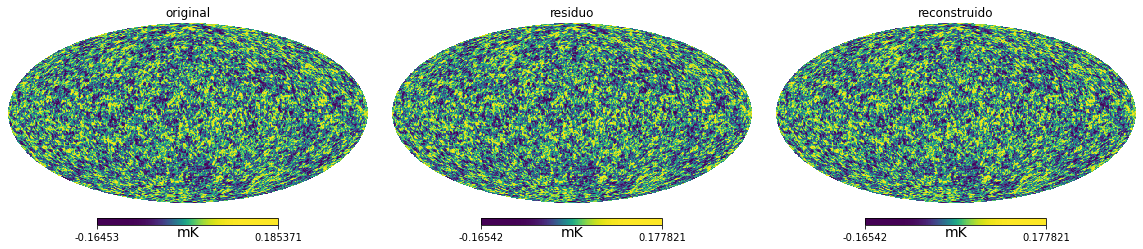

In [8]:
######################################################################################################
######## PLOTS
mapas=[input_21cm[13], Y['residual']['21cm'][13], Y['reconstruction']['21cm'][13]] #vetor com os mapas
titulos=['original', 'residuo', 'reconstruido'] #vetor com os nomes
plt.figure(figsize = (16,4))
for i in range(3):
        hp.mollview(mapas[i],sub = (1,3,i+1), norm='hist', title = titulos[i], nest=False, unit='mK' )
######################################################################################################

variância (rec-input):          0.0001194565123470941


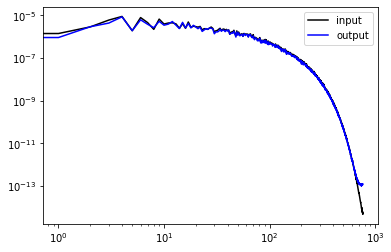

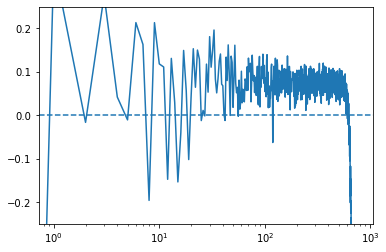

In [9]:
# Conferência dos erros
######################################################################################################
######## Cl's
cl_input = hp.anafast(input_21cm[13])
cl_output = hp.anafast(Y['reconstruction']['21cm'][13])
######################################################################################################

######################################################################################################
######## Comparação do espectro de potência do mapa 21cm com o 21cm reconstruido
plt.figure()
plt.plot(cl_input, color = 'black', label='input')
plt.plot(cl_output, color = 'blue', label='output')
plt.xscale('log')
plt.yscale('log')
plt.legend()
######################################################################################################

######################################################################################################
######## Erro grafico
plt.figure()
plt.plot((cl_input - cl_output)/cl_input)
plt.xscale('log')
plt.ylim(-0.25,0.25)
plt.axhline(y=0, linestyle='dashed')
######################################################################################################

######################################################################################################
######## Erro 
print('variância (rec-input):         ',np.var(Y['reconstruction']['21cm'][13] - input_21cm[13]))
######################################################################################################

In [10]:
######## Mudando parametros

In [11]:
#PARAMETROS ENTRADA 
######################################################################################################
########FastICA parametros de entrada da função
n = 5  #numero de componentes do ICA
whiten = True  ######## Só funciona se for True.
fun = 'logcosh' #função que aproxima
max_iter = 100 
tol = 0.0001
######################################################################################################

######################################################################################################
########## Wavelets
wtransform       = "starlet"
maps_wout_mean   = True
apply_mask       = False
add_noise        = False
J     = 3  #number of scales
use_c = True  # if you will use wavelet scale in the analysis


# If you to use wtransforms by S2Let code, please, fill in the variables below:
L        = None #If you write "None", it will use L=3*nside
J_min    = 1
B        = 10       
N        = 3  # Number of directions (This is for Directional only)
spin     = 0  # set to 0 for temperature. if non-zero, plotting routines must be changed! (This is for Directional only)
upsample = 0  # 1 means all scales at full resolution L # 0 means multiresolution wavelet transform (This is for Directional only)
######################################################################################################

In [12]:
#Coloca os parâmetros em uma variável só.
######################################################################################################
########
params_CS   = pd.Series({"n":n, "whiten":whiten, "fun":fun, "max_iter":max_iter, "tol":tol})
params_WT   = pd.Series({"wtransform":wtransform, "J":J, "use_c":use_c, "L":L, "Jmin":J_min, "B": B, "N":N, "spin":spin, "upsample":upsample})
######################################################################################################

In [13]:
X_wt = maps2ICAmaps(X, params_WT, params_CS)
Y = w2ICAmaps(X_wt, X, params_WT, params_CS)


Wavelet transforming the data . . .
. . completed in 9.23 minutes

Starting Component Analysis...
Building reconstructed maps...
Building residuals maps...
Finished in: 0.51 min


/home/luiz/anaconda3/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/luiz/anaconda3/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/home/luiz/anaconda3/lib/python3.8/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a reg

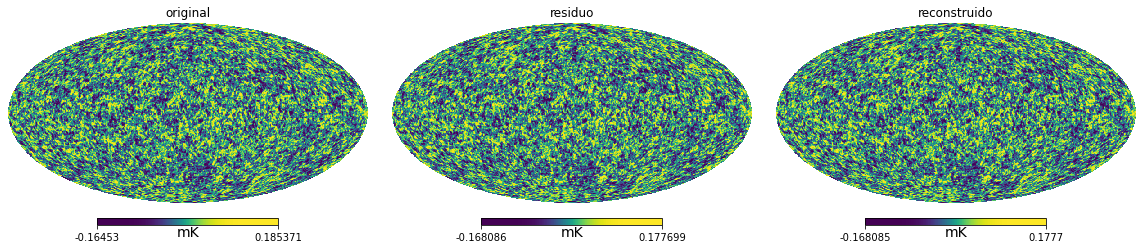

In [14]:
######################################################################################################
######## PLOTS
mapas=[input_21cm[13], Y['residual']['21cm'][13], Y['reconstruction']['21cm'][13]] #vetor com os mapas
titulos=['original', 'residuo', 'reconstruido'] #vetor com os nomes
plt.figure(figsize = (16,4))
for i in range(3):
        hp.mollview(mapas[i],sub = (1,3,i+1), norm='hist', title = titulos[i], nest=False, unit='mK' )
######################################################################################################

variância (rec-input):          0.00012385266742759134


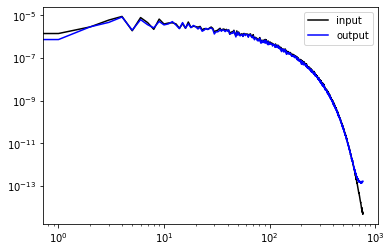

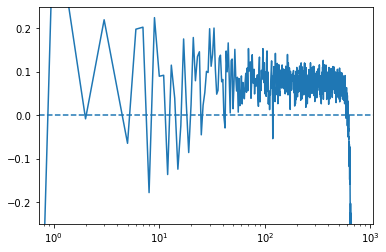

In [15]:
# Conferência dos erros
######################################################################################################
######## Cl's
cl_input = hp.anafast(input_21cm[13])
cl_output = hp.anafast(Y['reconstruction']['21cm'][13])
######################################################################################################

######################################################################################################
######## Comparação do espectro de potência do mapa 21cm com o 21cm reconstruido
plt.figure()
plt.plot(cl_input, color = 'black', label='input')
plt.plot(cl_output, color = 'blue', label='output')
plt.xscale('log')
plt.yscale('log')
plt.legend()
######################################################################################################

######################################################################################################
######## Erro grafico
plt.figure()
plt.plot((cl_input - cl_output)/cl_input)
plt.xscale('log')
plt.ylim(-0.25,0.25)
plt.axhline(y=0, linestyle='dashed')
######################################################################################################

######################################################################################################
######## Erro 
print('variância (rec-input):         ',np.var(Y['reconstruction']['21cm'][13] - input_21cm[13]))
######################################################################################################

In [18]:
######## Mudando parametros

In [18]:
#PARAMETROS ENTRADA 
######################################################################################################
########FastICA parametros de entrada da função
n = 5  #numero de componentes do ICA
whiten = True  ######## Só funciona se for True.
fun = 'logcosh' #função que aproxima
max_iter = 1000 
tol = 10e-7
######################################################################################################

######################################################################################################
########## Wavelets
wtransform       = "starlet"
maps_wout_mean   = True
apply_mask       = False
add_noise        = False
J     = 3  #number of scales
use_c = True  # if you will use wavelet scale in the analysis


# If you to use wtransforms by S2Let code, please, fill in the variables below:
L        = None #If you write "None", it will use L=3*nside
J_min    = 1
B        = 10       
N        = 3  # Number of directions (This is for Directional only)
spin     = 0  # set to 0 for temperature. if non-zero, plotting routines must be changed! (This is for Directional only)
upsample = 0  # 1 means all scales at full resolution L # 0 means multiresolution wavelet transform (This is for Directional only)
######################################################################################################

In [19]:
#Coloca os parâmetros em uma variável só.
######################################################################################################
########
params_CS   = pd.Series({"n":n, "whiten":whiten, "fun":fun, "max_iter":max_iter, "tol":tol})
params_WT   = pd.Series({"wtransform":wtransform, "J":J, "use_c":use_c, "L":L, "Jmin":J_min, "B": B, "N":N, "spin":spin, "upsample":upsample})
######################################################################################################

In [20]:
Y = w2ICAmaps(X_wt, X, params_WT, params_CS)
print(Y.keys())

Starting Component Analysis...
Building reconstructed maps...
Building residuals maps...
Finished in: 0.45 min
dict_keys(['reconstruction', 'residual', 'mixmatrix'])


/home/luiz/anaconda3/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/luiz/anaconda3/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/home/luiz/anaconda3/lib/python3.8/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a reg

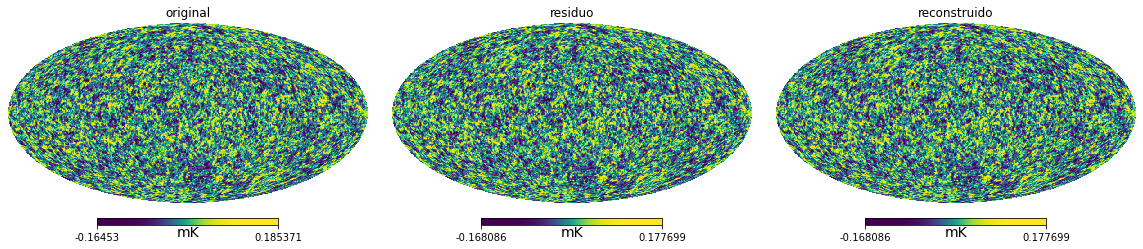

In [21]:
######################################################################################################
######## PLOTS
mapas=[input_21cm[13], Y['residual']['21cm'][13], Y['reconstruction']['21cm'][13]] #vetor com os mapas
titulos=['original', 'residuo', 'reconstruido'] #vetor com os nomes
plt.figure(figsize = (16,4))
for i in range(3):
        hp.mollview(mapas[i],sub = (1,3,i+1), norm='hist', title = titulos[i], nest=False, unit='mK' )
######################################################################################################

variância (rec-input):          0.00012385341187982752


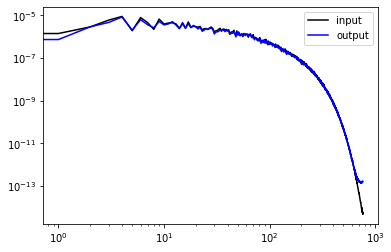

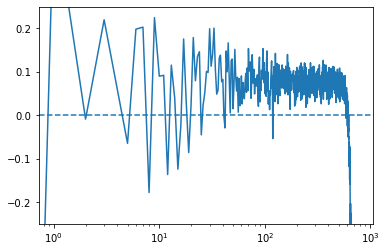

In [22]:
# Conferência dos erros
######################################################################################################
######## Cl's
cl_input = hp.anafast(input_21cm[13])
cl_output = hp.anafast(Y['reconstruction']['21cm'][13])
######################################################################################################

######################################################################################################
######## Comparação do espectro de potência do mapa 21cm com o 21cm reconstruido
plt.figure()
plt.plot(cl_input, color = 'black', label='input')
plt.plot(cl_output, color = 'blue', label='output')
plt.xscale('log')
plt.yscale('log')
plt.legend()
######################################################################################################

######################################################################################################
######## Erro grafico
plt.figure()
plt.plot((cl_input - cl_output)/cl_input)
plt.xscale('log')
plt.ylim(-0.25,0.25)
plt.axhline(y=0, linestyle='dashed')
######################################################################################################

######################################################################################################
######## Erro 
print('variância (rec-input):         ',np.var(Y['reconstruction']['21cm'][13] - input_21cm[13]))
######################################################################################################

In [27]:
#PARAMETROS ENTRADA 
######################################################################################################
########FastICA parametros de entrada da função
n = 5  #numero de componentes do ICA
whiten = True  ######## Só funciona se for True.
fun = 'logcosh' #função que aproxima
max_iter = 1000000 
tol = 10e-7
######################################################################################################

######################################################################################################
########## Wavelets
wtransform       = "starlet"
maps_wout_mean   = True
apply_mask       = False
add_noise        = False
J     = 3  #number of scales
use_c = True  # if you will use wavelet scale in the analysis


# If you to use wtransforms by S2Let code, please, fill in the variables below:
L        = None #If you write "None", it will use L=3*nside
J_min    = 1
B        = 10       
N        = 3  # Number of directions (This is for Directional only)
spin     = 0  # set to 0 for temperature. if non-zero, plotting routines must be changed! (This is for Directional only)
upsample = 0  # 1 means all scales at full resolution L # 0 means multiresolution wavelet transform (This is for Directional only)
######################################################################################################

In [28]:
#Coloca os parâmetros em uma variável só.
######################################################################################################
########
params_CS   = pd.Series({"n":n, "whiten":whiten, "fun":fun, "max_iter":max_iter, "tol":tol})
params_WT   = pd.Series({"wtransform":wtransform, "J":J, "use_c":use_c, "L":L, "Jmin":J_min, "B": B, "N":N, "spin":spin, "upsample":upsample})
######################################################################################################

In [29]:
Y = w2ICAmaps(X_wt, X, params_WT, params_CS)

Starting Component Analysis...
Building reconstructed maps...
Building residuals maps...
Finished in: 0.46 min


In [30]:
######################################################################################################
######## Erro 
print('variância (rec-input):         ',np.var(Y['reconstruction']['21cm'][13] - input_21cm[13]))
######################################################################################################

variância (rec-input):          0.0001238525961751249
